In [1]:
import torch as t
from scipy import ndimage
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
#device = t.device('cuda' if t.cuda.is_available() else 'cpu')
device = t.device('cpu')

In [3]:
MOORE_OFFSETS = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (0, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device)
def get_moore_nbh(batch:t.Tensor):
    _, batch_height, _ = batch.shape
    cell_pixel_coords = (batch == 1).nonzero()
    nbh_coords = (cell_pixel_coords[:, 1:].unsqueeze(1)+MOORE_OFFSETS.type(t.float).unsqueeze(0))
    idx_pad = cell_pixel_coords[:, 0].repeat(9,1).T.reshape(cell_pixel_coords[:, 0].shape[0], 9, 1)
    nbh_coords[nbh_coords == -1] = 1
    nbh_coords[nbh_coords == batch_height] = batch_height -2
    return t.concatenate((idx_pad, nbh_coords), dim=-1)

In [44]:
STEP_SIZES = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device)

def MCS(batch, temperature):
    batch_size, batch_height, _ = batch.shape
    
    #########################################################
    # 1. Find source and target coordinates for each sample #
    #########################################################
    # Find all pixels that belong to a cell, or border a cell 
    frontiers = get_moore_nbh(batch)
    src_coords = []
    for batch_idx in range(batch_size):
        frontier = frontiers[frontiers[:, :, 0] == batch_idx, :].unique(dim=0)
        src_coords.append(random.choice(frontier).type(t.long))
    batch_src_coords = t.vstack(src_coords)
    step_sizes = t.vstack(random.choices(STEP_SIZES, k=batch_src_coords.shape[0]))
    tgt_coords = t.hstack((batch_src_coords[:, 0].unsqueeze(0).T, batch_src_coords[:, 1:] + step_sizes))
    tgt_coords[:, 1:][tgt_coords[:, 1:] == -1] = 1
    tgt_coords[:, 1:][tgt_coords[:, 1:] == batch_height] = batch_height -2
    tgt_i = tgt_coords[:, 0]
    tgt_j = tgt_coords[:, 1]
    tgt_k = tgt_coords[:, 2]
    src_i = batch_src_coords[:, 0]
    src_j = batch_src_coords[:, 1]
    src_k = batch_src_coords[:, 2]
    
    #########################################################################
    # 2. Calculate the changes in volume that the copy attempts would cause #
    #########################################################################
    current_volumes = t.sum(batch, dim=(-1, -2))
    vol_changes = (-1 * batch[tgt_i, tgt_j, tgt_k]) + batch[src_i, src_j, src_k]
    adjusted_vols = current_volumes + vol_changes
    
    #########################################################
    # 3. Define boolean masks based on the volume changes   #
    #########################################################
    sml_eq_two_mask = adjusted_vols <= 2
    greater_zero_mask = adjusted_vols > 0
    vol_change_positive_mask = vol_changes > 0
    vol_change_negative_mask = vol_changes < 0
    
    #########################################################
    # 4. auto accept each attempt with negative vol. change #
    # that fulfills the hard volume constraint              #
    #########################################################
    auto_upd_mask = t.logical_and(
        vol_change_negative_mask,
        greater_zero_mask
    )
    auto_upd_i = tgt_i[auto_upd_mask]
    auto_upd_j = tgt_j[auto_upd_mask]
    auto_upd_k = tgt_k[auto_upd_mask]
    batch[auto_upd_i, auto_upd_j, auto_upd_k] += vol_changes[auto_upd_mask]
    
    ##################################################################
    # 5. stochastic update of the attempts with positive vol. change #
    ################################################################## 
    update_mask = t.logical_and(
        vol_change_positive_mask,
        sml_eq_two_mask
    )
    update_probability = t.exp(-temperature)
    logit = t.log(t.hstack((update_probability, (1-update_probability))))
    batch_logits = logit.repeat((vol_changes[update_mask].shape[0],1))
    one_hot = t.nn.functional.gumbel_softmax(batch_logits, hard=True)
    
    upd_vals = one_hot[:, 0] * vol_changes[update_mask]
    upd_i = tgt_i[update_mask]
    upd_j = tgt_j[update_mask]
    upd_k = tgt_k[update_mask]
    batch[upd_i, upd_j, upd_k] += upd_vals.squeeze()
    
    return batch
    

In [50]:
temperature = t.tensor(1.)
target_vol = 1.
batch = t.zeros(1,256,256, device=device)
batch[:,128,128] += 1

states = []
for i in tqdm(range(1000)):
    batch = MCS(batch, temperature)
    if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
        print("ISSUE DETECTED, STOP SIM")
        break
    else:
        states.append(batch[0].detach().clone().cpu().numpy())

imgs = [Image.fromarray((1-state)*255) for state in states]
print(len(imgs))
imgs[0].save("test.gif", save_all=True, append_images=imgs[1:], fps=20)

100%|██████████| 1000/1000 [00:01<00:00, 623.17it/s]


1000


In [51]:
def create_dist_matrix(batch:t.Tensor):
    dist_matrix:np.ndarray = ndimage.distance_transform_edt(1-batch[0].cpu(), return_indices=False)
    dist_matrix = dist_matrix**2
    dist_matrix_t = t.from_numpy(dist_matrix).to(device)
    return dist_matrix_t

In [52]:
def step(batch:t.Tensor, dist_matrix:t.Tensor, temperature:t.Tensor, eta:float, num_steps:int, target_distance:float):
    for i in tqdm(range(num_steps)):
        batch = MCS(batch, temperature)
        if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
            print("ISSUE DETECTED, STOP SIM")
            return None, None
    # calc the distance after 100 steps    
    distances = t.sum(batch * dist_matrix, dim=(-1,-2)) / t.sum(batch, dim=(-1,-2))
    mean_distance = t.mean(distances)
    print(f"temperature: {temperature}, update_prob:{t.exp(-temperature)} mean distance: {mean_distance}")
    loss = (mean_distance - target_distance)**2
    grad = t.autograd.grad(loss, temperature)[0]
    print(f"gradient: {grad}")
    return t.clamp(temperature - (eta * grad), min=1e-5, max=40.), grad, mean_distance, loss

In [ ]:
temps = t.linspace(0,5,30)
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.

grads = []
mean_distances = []
losses = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, eta=1, num_steps=40, target_distance=target_distance)
    grads.append(grad.detach().cpu().numpy())
    mean_distances.append(mean_distance.detach().cpu().numpy())
    losses.append(loss.detach().cpu().numpy())

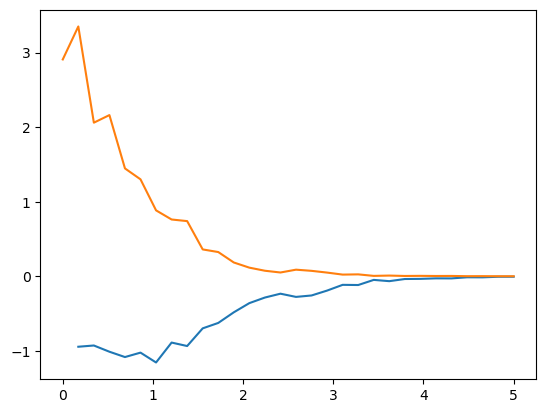

In [54]:
plt.plot(temps.cpu(), grads)
plt.plot(temps.cpu(), losses)

In [ ]:
temps = t.linspace(0,5,100)
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 1.

grads = []
mean_distances = []
losses = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(1000,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads.append(grad.detach().cpu().numpy())
    mean_distances.append(mean_distance.detach().cpu().numpy())
    losses.append(loss.detach().cpu().numpy())

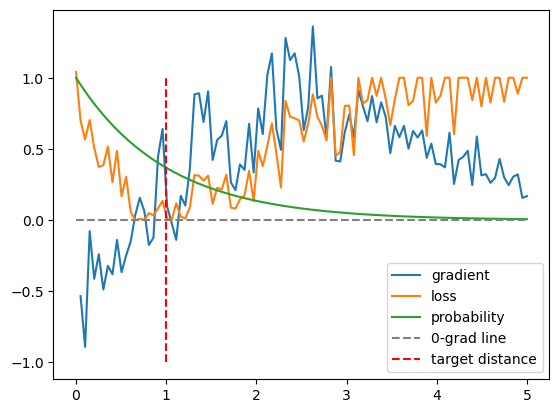

In [52]:
plt.plot(temps.cpu(), grads, label="gradient")
plt.plot(temps.cpu(), losses, label="loss")
plt.plot(temps.cpu(), t.exp(-temps).cpu(), label="probability")

plt.hlines(y=[0.], xmin=0, xmax=5, label="0-grad line", linestyles="dashed", colors=["gray"])
plt.vlines(x=[target_distance], ymin=-1, ymax=1, label="target distance", linestyles="dashed", colors=["red"])

plt.legend()
plt.show()

In [ ]:
temps = t.linspace(0,5,100)
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 1.

grads = []
mean_distances = []
losses = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(1000,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=100, target_distance=target_distance)
    grads.append(grad.detach().cpu().numpy())
    mean_distances.append(mean_distance.detach().cpu().numpy())
    losses.append(loss.detach().cpu().numpy())

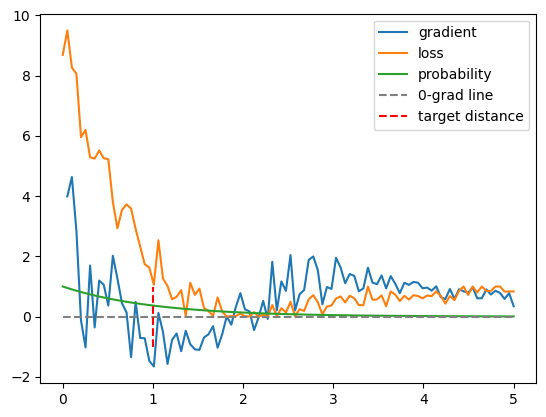

In [54]:
plt.plot(temps.cpu(), grads, label="gradient")
plt.plot(temps.cpu(), losses, label="loss")
plt.plot(temps.cpu(), t.exp(-temps).cpu(), label="probability")

plt.hlines(y=[0.], xmin=0, xmax=5, label="0-grad line", linestyles="dashed", colors=["gray"])
plt.vlines(x=[target_distance], ymin=-1, ymax=1, label="target distance", linestyles="dashed", colors=["red"])

plt.legend()
plt.show()

In [62]:
temps = t.linspace(0,5,100)
target_vol = 1.
ref = t.zeros(1,256,256, device=device)
ref[:,128,128] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 1.

grads = []
mean_distances = []
losses = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,256,256, device=device)
    batch[:,128,128] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=1000, target_distance=target_distance)
    grads.append(grad.detach().cpu().numpy())
    mean_distances.append(mean_distance.detach().cpu().numpy())
    losses.append(loss.detach().cpu().numpy())

100%|██████████| 1000/1000 [00:33<00:00, 29.46it/s]


temperature: 0.0, update_prob:1.0 mean distance: 43.825
gradient: nan


100%|██████████| 1000/1000 [00:34<00:00, 28.73it/s]


temperature: 0.05050504952669144, update_prob:0.9507490992546082 mean distance: 39.7
gradient: 10508.7294921875


100%|██████████| 1000/1000 [00:34<00:00, 28.83it/s]


temperature: 0.10101009905338287, update_prob:0.9039239287376404 mean distance: 35.92
gradient: 11740.2236328125


100%|██████████| 1000/1000 [00:35<00:00, 28.30it/s]


temperature: 0.1515151560306549, update_prob:0.8594048619270325 mean distance: 45.695
gradient: 14632.3251953125


100%|██████████| 1000/1000 [00:35<00:00, 28.17it/s]


temperature: 0.20202019810676575, update_prob:0.8170784115791321 mean distance: 48.24
gradient: 25720.78515625


100%|██████████| 1000/1000 [00:35<00:00, 28.29it/s]


temperature: 0.2525252401828766, update_prob:0.7768365740776062 mean distance: 43.105
gradient: 14602.0126953125


100%|██████████| 1000/1000 [00:35<00:00, 28.16it/s]


temperature: 0.3030303120613098, update_prob:0.7385767102241516 mean distance: 38.335
gradient: 15083.4189453125


100%|██████████| 1000/1000 [00:35<00:00, 28.21it/s]


temperature: 0.35353535413742065, update_prob:0.7022011876106262 mean distance: 39.565
gradient: 12726.66015625


100%|██████████| 1000/1000 [00:35<00:00, 28.40it/s]


temperature: 0.4040403962135315, update_prob:0.66761714220047 mean distance: 36.09
gradient: 10851.92578125


100%|██████████| 1000/1000 [00:35<00:00, 28.38it/s]


temperature: 0.45454543828964233, update_prob:0.6347364187240601 mean distance: 36.825
gradient: 11062.1611328125


100%|██████████| 1000/1000 [00:35<00:00, 28.11it/s]


temperature: 0.5050504803657532, update_prob:0.6034750938415527 mean distance: 31.4
gradient: 9482.8359375


100%|██████████| 1000/1000 [00:35<00:00, 28.20it/s]


temperature: 0.5555555820465088, update_prob:0.5737534165382385 mean distance: 32.61
gradient: 9120.884765625


100%|██████████| 1000/1000 [00:35<00:00, 28.41it/s]


temperature: 0.6060606241226196, update_prob:0.5454955697059631 mean distance: 37.83
gradient: 14192.2587890625


100%|██████████| 1000/1000 [00:35<00:00, 28.48it/s]


temperature: 0.6565656661987305, update_prob:0.5186294317245483 mean distance: 30.185
gradient: 9211.40625


100%|██████████| 1000/1000 [00:35<00:00, 28.32it/s]


temperature: 0.7070707082748413, update_prob:0.49308648705482483 mean distance: 29.79
gradient: 6735.86572265625


100%|██████████| 1000/1000 [00:34<00:00, 28.65it/s]


temperature: 0.7575757503509521, update_prob:0.4688015282154083 mean distance: 24.605
gradient: 5425.54248046875


100%|██████████| 1000/1000 [00:35<00:00, 28.56it/s]


temperature: 0.808080792427063, update_prob:0.4457126557826996 mean distance: 26.41
gradient: 6196.85107421875


100%|██████████| 1000/1000 [00:34<00:00, 28.70it/s]


temperature: 0.8585858345031738, update_prob:0.42376092076301575 mean distance: 30.845
gradient: 9839.4052734375


100%|██████████| 1000/1000 [00:35<00:00, 28.44it/s]


temperature: 0.9090908765792847, update_prob:0.40289032459259033 mean distance: 29.235
gradient: 7389.91748046875


100%|██████████| 1000/1000 [00:34<00:00, 28.68it/s]


temperature: 0.9595959186553955, update_prob:0.3830476403236389 mean distance: 20.72
gradient: 4987.47900390625


100%|██████████| 1000/1000 [00:34<00:00, 28.58it/s]


temperature: 1.0101009607315063, update_prob:0.3641822040081024 mean distance: 24.51
gradient: 5512.0048828125


100%|██████████| 1000/1000 [00:34<00:00, 28.81it/s]


temperature: 1.0606060028076172, update_prob:0.3462459146976471 mean distance: 24.375
gradient: 5984.4052734375


100%|██████████| 1000/1000 [00:34<00:00, 28.93it/s]


temperature: 1.1111111640930176, update_prob:0.32919296622276306 mean distance: 19.93
gradient: 3423.00732421875


100%|██████████| 1000/1000 [00:35<00:00, 27.98it/s]


temperature: 1.1616160869598389, update_prob:0.31297996640205383 mean distance: 23.905
gradient: 7084.140625


100%|██████████| 1000/1000 [00:34<00:00, 29.06it/s]


temperature: 1.2121212482452393, update_prob:0.29756540060043335 mean distance: 21.11
gradient: 4440.392578125


100%|██████████| 1000/1000 [00:34<00:00, 29.14it/s]


temperature: 1.26262629032135, update_prob:0.2829100489616394 mean distance: 20.42
gradient: 4553.27734375


100%|██████████| 1000/1000 [00:34<00:00, 28.62it/s]


temperature: 1.313131332397461, update_prob:0.26897647976875305 mean distance: 18.985
gradient: 3045.072265625


100%|██████████| 1000/1000 [00:34<00:00, 28.85it/s]


temperature: 1.3636363744735718, update_prob:0.25572916865348816 mean distance: 15.87
gradient: 1389.828125


100%|██████████| 1000/1000 [00:34<00:00, 29.10it/s]


temperature: 1.4141414165496826, update_prob:0.2431342750787735 mean distance: 17.94
gradient: 2753.208984375


100%|██████████| 1000/1000 [00:34<00:00, 29.28it/s]


temperature: 1.4646464586257935, update_prob:0.23115970194339752 mean distance: 17.835
gradient: 2783.743408203125


100%|██████████| 1000/1000 [00:35<00:00, 28.52it/s]


temperature: 1.5151515007019043, update_prob:0.21977488696575165 mean distance: 13.89
gradient: 1854.97900390625


100%|██████████| 1000/1000 [00:35<00:00, 28.45it/s]


temperature: 1.5656566619873047, update_prob:0.20895075798034668 mean distance: 15.42
gradient: 1598.6337890625


100%|██████████| 1000/1000 [00:35<00:00, 27.98it/s]


temperature: 1.616161584854126, update_prob:0.1986597776412964 mean distance: 15.585
gradient: 2329.646240234375


100%|██████████| 1000/1000 [00:37<00:00, 26.79it/s]


temperature: 1.6666666269302368, update_prob:0.18887561559677124 mean distance: 14.86
gradient: 1841.482666015625


100%|██████████| 1000/1000 [00:32<00:00, 31.16it/s]


temperature: 1.7171716690063477, update_prob:0.17957332730293274 mean distance: 12.27
gradient: 1039.4488525390625


100%|██████████| 1000/1000 [00:31<00:00, 31.46it/s]


temperature: 1.7676767110824585, update_prob:0.17072917520999908 mean distance: 11.445
gradient: 857.0413208007812


100%|██████████| 1000/1000 [00:32<00:00, 31.23it/s]


temperature: 1.8181817531585693, update_prob:0.16232061386108398 mean distance: 13.12
gradient: 1191.24072265625


100%|██████████| 1000/1000 [00:34<00:00, 28.72it/s]


temperature: 1.8686867952346802, update_prob:0.1543261855840683 mean distance: 11.435
gradient: 1077.0537109375


100%|██████████| 1000/1000 [00:31<00:00, 31.26it/s]


temperature: 1.919191837310791, update_prob:0.14672549068927765 mean distance: 9.36
gradient: 463.1342468261719


100%|██████████| 1000/1000 [00:31<00:00, 31.52it/s]


temperature: 1.9696969985961914, update_prob:0.13949911296367645 mean distance: 8.505
gradient: 393.4420166015625


100%|██████████| 1000/1000 [00:33<00:00, 30.27it/s]


temperature: 2.0202019214630127, update_prob:0.1326286792755127 mean distance: 9.725
gradient: 776.3914794921875


100%|██████████| 1000/1000 [00:32<00:00, 30.50it/s]


temperature: 2.070707082748413, update_prob:0.12609659135341644 mean distance: 8.01
gradient: 267.34271240234375


100%|██████████| 1000/1000 [00:31<00:00, 31.52it/s]


temperature: 2.1212120056152344, update_prob:0.11988623440265656 mean distance: 9.835
gradient: 448.03143310546875


100%|██████████| 1000/1000 [00:31<00:00, 31.46it/s]


temperature: 2.1717171669006348, update_prob:0.11398172378540039 mean distance: 7.11
gradient: 261.3222961425781


100%|██████████| 1000/1000 [00:31<00:00, 31.66it/s]


temperature: 2.222222089767456, update_prob:0.10836803913116455 mean distance: 8.655
gradient: 338.8981018066406


100%|██████████| 1000/1000 [00:31<00:00, 31.68it/s]


temperature: 2.2727272510528564, update_prob:0.10303080826997757 mean distance: 10.885
gradient: 848.747802734375


100%|██████████| 1000/1000 [00:31<00:00, 31.85it/s]


temperature: 2.3232321739196777, update_prob:0.09795646369457245 mean distance: 9.065
gradient: 445.6803894042969


100%|██████████| 1000/1000 [00:31<00:00, 31.85it/s]


temperature: 2.373737335205078, update_prob:0.09313201159238815 mean distance: 7.025
gradient: 224.2076416015625


100%|██████████| 1000/1000 [00:31<00:00, 31.88it/s]


temperature: 2.4242424964904785, update_prob:0.08854516595602036 mean distance: 5.795
gradient: 138.25538635253906


100%|██████████| 1000/1000 [00:36<00:00, 27.65it/s]


temperature: 2.474747657775879, update_prob:0.08418422937393188 mean distance: 7.745
gradient: 315.2007141113281


100%|██████████| 1000/1000 [00:34<00:00, 29.30it/s]


temperature: 2.5252525806427, update_prob:0.08003809303045273 mean distance: 6.75
gradient: 209.9229736328125


100%|██████████| 1000/1000 [00:35<00:00, 27.88it/s]


temperature: 2.5757577419281006, update_prob:0.07609613984823227 mean distance: 4.21
gradient: 47.30175018310547


100%|██████████| 1000/1000 [00:33<00:00, 30.12it/s]


temperature: 2.626262664794922, update_prob:0.07234834879636765 mean distance: 6.82
gradient: 224.5637969970703


100%|██████████| 1000/1000 [00:32<00:00, 31.08it/s]


temperature: 2.6767678260803223, update_prob:0.06878512352705002 mean distance: 4.41
gradient: 28.027149200439453


100%|██████████| 1000/1000 [00:31<00:00, 31.78it/s]


temperature: 2.7272727489471436, update_prob:0.06539740413427353 mean distance: 7.365
gradient: 227.81663513183594


100%|██████████| 1000/1000 [00:31<00:00, 31.79it/s]


temperature: 2.777777910232544, update_prob:0.06217651441693306 mean distance: 5.705
gradient: 103.2613296508789


100%|██████████| 1000/1000 [00:31<00:00, 32.05it/s]


temperature: 2.8282828330993652, update_prob:0.05911427363753319 mean distance: 3.745
gradient: 34.2677116394043


100%|██████████| 1000/1000 [00:31<00:00, 31.94it/s]


temperature: 2.8787879943847656, update_prob:0.05620284005999565 mean distance: 4.84
gradient: 67.60711669921875


100%|██████████| 1000/1000 [00:32<00:00, 31.18it/s]


temperature: 2.929292917251587, update_prob:0.05343480780720711 mean distance: 3.08
gradient: -1.4586642980575562


100%|██████████| 1000/1000 [00:34<00:00, 28.85it/s]


temperature: 2.9797980785369873, update_prob:0.05080309137701988 mean distance: 4.775
gradient: 63.261295318603516


100%|██████████| 1000/1000 [00:31<00:00, 31.41it/s]


temperature: 3.0303030014038086, update_prob:0.04830100014805794 mean distance: 4.865
gradient: 65.76649475097656


100%|██████████| 1000/1000 [00:31<00:00, 32.04it/s]


temperature: 3.080808162689209, update_prob:0.04592213034629822 mean distance: 4.26
gradient: 20.74944496154785


100%|██████████| 1000/1000 [00:31<00:00, 32.00it/s]


temperature: 3.1313130855560303, update_prob:0.04366042837500572 mean distance: 3.93
gradient: 15.852052688598633


100%|██████████| 1000/1000 [00:32<00:00, 30.95it/s]


temperature: 3.1818182468414307, update_prob:0.04151010885834694 mean distance: 3.355
gradient: 7.464229106903076


100%|██████████| 1000/1000 [00:32<00:00, 30.40it/s]


temperature: 3.232323169708252, update_prob:0.039465706795454025 mean distance: 2.82
gradient: 6.089916706085205


100%|██████████| 1000/1000 [00:34<00:00, 28.95it/s]


temperature: 3.2828283309936523, update_prob:0.037521980702877045 mean distance: 2.39
gradient: -4.456838607788086


100%|██████████| 1000/1000 [00:33<00:00, 29.74it/s]


temperature: 3.3333332538604736, update_prob:0.035673994570970535 mean distance: 2.86
gradient: 2.416074514389038


100%|██████████| 1000/1000 [00:31<00:00, 31.80it/s]


temperature: 3.383838415145874, update_prob:0.03391701728105545 mean distance: 2.55
gradient: -1.4237645864486694


100%|██████████| 1000/1000 [00:31<00:00, 31.59it/s]


temperature: 3.4343433380126953, update_prob:0.032246578484773636 mean distance: 2.095
gradient: 0.005286017432808876


100%|██████████| 1000/1000 [00:31<00:00, 31.61it/s]


temperature: 3.4848484992980957, update_prob:0.030658403411507607 mean distance: 2.7
gradient: 3.455620527267456


100%|██████████| 1000/1000 [00:31<00:00, 32.04it/s]


temperature: 3.535353422164917, update_prob:0.02914845384657383 mean distance: 2.68
gradient: -2.0341243743896484


100%|██████████| 1000/1000 [00:31<00:00, 31.99it/s]


temperature: 3.5858585834503174, update_prob:0.027712862938642502 mean distance: 1.48
gradient: -3.2895729541778564


100%|██████████| 1000/1000 [00:31<00:00, 31.79it/s]


temperature: 3.6363635063171387, update_prob:0.02634798362851143 mean distance: 2.13
gradient: -5.229175090789795


100%|██████████| 1000/1000 [00:31<00:00, 31.52it/s]


temperature: 3.686868667602539, update_prob:0.025050319731235504 mean distance: 2.45
gradient: -0.559561550617218


100%|██████████| 1000/1000 [00:31<00:00, 31.70it/s]


temperature: 3.7373735904693604, update_prob:0.02381657250225544 mean distance: 1.525
gradient: -2.777890682220459


100%|██████████| 1000/1000 [00:31<00:00, 31.45it/s]


temperature: 3.7878787517547607, update_prob:0.02264358289539814 mean distance: 1.76
gradient: -2.801478624343872


100%|██████████| 1000/1000 [00:31<00:00, 31.72it/s]


temperature: 3.838383674621582, update_prob:0.021528370678424835 mean distance: 2.19
gradient: -1.0167903900146484


100%|██████████| 1000/1000 [00:31<00:00, 31.77it/s]


temperature: 3.8888888359069824, update_prob:0.020468076691031456 mean distance: 1.82
gradient: -4.296122074127197


100%|██████████| 1000/1000 [00:31<00:00, 31.64it/s]


temperature: 3.9393937587738037, update_prob:0.019460009410977364 mean distance: 0.96
gradient: 0.36796829104423523


100%|██████████| 1000/1000 [00:31<00:00, 31.86it/s]


temperature: 3.989898920059204, update_prob:0.018501583486795425 mean distance: 1.75
gradient: -4.857827663421631


100%|██████████| 1000/1000 [00:31<00:00, 31.70it/s]


temperature: 4.040404319763184, update_prob:0.01759035885334015 mean distance: 1.855
gradient: -4.437930107116699


100%|██████████| 1000/1000 [00:31<00:00, 31.51it/s]


temperature: 4.090909481048584, update_prob:0.01672401651740074 mean distance: 1.8
gradient: -1.6507291793823242


100%|██████████| 1000/1000 [00:31<00:00, 31.82it/s]


temperature: 4.141414642333984, update_prob:0.015900341793894768 mean distance: 1.88
gradient: -1.0910861492156982


100%|██████████| 1000/1000 [00:31<00:00, 32.07it/s]


temperature: 4.191919326782227, update_prob:0.015117242000997066 mean distance: 1.1
gradient: -0.6925700902938843


100%|██████████| 1000/1000 [00:31<00:00, 31.63it/s]


temperature: 4.242424488067627, update_prob:0.014372702687978745 mean distance: 0.95
gradient: 0.42166563868522644


100%|██████████| 1000/1000 [00:31<00:00, 31.88it/s]


temperature: 4.292929649353027, update_prob:0.013664833270013332 mean distance: 1.25
gradient: -1.47821843624115


100%|██████████| 1000/1000 [00:31<00:00, 31.89it/s]


temperature: 4.343434810638428, update_prob:0.012991826981306076 mean distance: 1.07
gradient: -0.46428796648979187


100%|██████████| 1000/1000 [00:31<00:00, 31.97it/s]


temperature: 4.39393949508667, update_prob:0.012351972982287407 mean distance: 1.91
gradient: -5.107141017913818


100%|██████████| 1000/1000 [00:31<00:00, 31.75it/s]


temperature: 4.44444465637207, update_prob:0.01174362562596798 mean distance: 0.53
gradient: 3.0153167247772217


100%|██████████| 1000/1000 [00:31<00:00, 32.02it/s]


temperature: 4.494949817657471, update_prob:0.011165240779519081 mean distance: 1.1600000000000004
gradient: -0.5342100858688354


100%|██████████| 1000/1000 [00:31<00:00, 31.86it/s]


temperature: 4.545454978942871, update_prob:0.010615342296659946 mean distance: 1.0000000000000002
gradient: -1.251838463076603e-15


100%|██████████| 1000/1000 [00:31<00:00, 31.93it/s]


temperature: 4.595959663391113, update_prob:0.010092530399560928 mean distance: 0.7900000000000001
gradient: 1.059441328048706


100%|██████████| 1000/1000 [00:31<00:00, 32.07it/s]


temperature: 4.646464824676514, update_prob:0.00959546398371458 mean distance: 0.59
gradient: 2.446708917617798


100%|██████████| 1000/1000 [00:31<00:00, 31.76it/s]


temperature: 4.696969985961914, update_prob:0.009122877381742 mean distance: 1.69
gradient: -1.4723551273345947


100%|██████████| 1000/1000 [00:31<00:00, 31.93it/s]


temperature: 4.7474751472473145, update_prob:0.008673567324876785 mean distance: 1.1600000000000001
gradient: -0.7641897201538086


100%|██████████| 1000/1000 [00:31<00:00, 31.97it/s]


temperature: 4.797979831695557, update_prob:0.008246389217674732 mean distance: 0.69
gradient: 1.745822787284851


100%|██████████| 1000/1000 [00:31<00:00, 31.96it/s]


temperature: 4.848484992980957, update_prob:0.007840246893465519 mean distance: 0.27
gradient: 4.289221286773682


100%|██████████| 1000/1000 [00:31<00:00, 31.75it/s]


temperature: 4.898989677429199, update_prob:0.007454110309481621 mean distance: 0.3600000000000001
gradient: 3.7797493934631348


100%|██████████| 1000/1000 [00:31<00:00, 31.75it/s]


temperature: 4.9494948387146, update_prob:0.0070869880728423595 mean distance: 0.53
gradient: 2.7129902839660645


100%|██████████| 1000/1000 [00:31<00:00, 32.07it/s]


temperature: 5.0, update_prob:0.0067379469983279705 mean distance: 0.45
gradient: 2.705386161804199
